# Discretization Classification 2.0(Template) - KFold
## Author: Ming

## Import Package

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## 1.Load Data

In [2]:
# Load Data
data_name = "Germany_Original"
#Fast: Japanese_Credit Australian_Original Germany_Original Japanese_Bankrupt 
#Slow: USA_Bankrupt

#Discretize Good: Kaggle Tsai Bankruptcy Australia JPNCredit
#
if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
 

## 2.Sampling

In [3]:
# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values

In [4]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 1000
特徵數量(不含Target) :: 24


In [5]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts)) #Major:1 ; minor2

{1: 700, 2: 300}

## Discretization_Python
Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [6]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            replace_coloumn.sort()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## Discretization Utility

In [7]:
class Discretization_utility:
    def __init__(self, continuous_data, discretize_coloumn):
        self.continuous_data_dataframe = continuous_data
        self.discretize_coloumn = discretize_coloumn

    # Deprecated
#     def SelectFeatures(self): ##Split Specific to Discretize
#         idx_IN_columns = self.discretize_coloumn
#         idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
#         selectData_list = self.training_data[:,idx_IN_columns]
#         disSelectData_list = self.training_data[:,idx_OUT_columns]
#         return selectData_list , disSelectData_list
    
    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.continuous_data_dataframe)[1]) if i not in idx_IN_columns]
        selectData_list = self.continuous_data_dataframe.iloc[:,idx_IN_columns]
        disSelectData_list = self.continuous_data_dataframe.iloc[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
    
    def PrintFirstFiveData(self,data,dataname): ##Split Specific to Discretize
        #print("["+str(dataname)+"]")
        #print(data.head(5))
        return 0
     

## Discretization with R
R package'Discretization'

In [8]:
class Discretization_rpy2:
    ## Input:X_train,y_train,X_test,y_test,discretize_coloumn,method
    ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe
    
    def discretize(X_train,y_train,X_test,y_test,discretize_coloumn,method):

        # Declare Discretizer_rpy2 (Select Continuous Feature, PrintFirstFive)
        discretize_train = Discretization_utility(X_train,discretize_coloumn)

        # Select Continuous Feature (Training Data Continuous Feature)
        X_train_continuousData_list, X_train_catrgorialData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns


        # Convert data to Dataframe for R Package "Discretization"
        ## R 'Discretization' require Continuous Data(X_Train_SelectData) and Target(y_Train) in the last column
        X_train_continuousData_dataframe = pd.DataFrame(X_train_continuousData_list)
        y_train_dataframe = pd.DataFrame(y_train)

        # Combine Select Continuous with Target
        X_y_train_continuousData_dataframe = pd.concat([X_train_continuousData_dataframe, y_train_dataframe],axis=1)
        X_y_train_continuousData_dataframe.columns = range(X_y_train_continuousData_dataframe.shape[1]) #Reshape for column index
        discretize_train.PrintFirstFiveData(X_y_train_continuousData_dataframe,"X_y_train_continuousData_dataframe")


        # Import R Package
        discretization = importr("discretization")
        disc_Topdown = robjects.r("disc.Topdown")

        print("-------------------------------"+method+" -----------------------------")

        # Discretize (R Package)
        ## Input: pandas.DataFrame  Output: rpy2.DataFrame
        if method == 'MDLP_R':
            X_y_train_disData_rpy2dataframe = discretization.mdlp(X_y_train_continuousData_dataframe)
        elif method == 'CAIM_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=1)
        elif method == 'ChiMerge_R':
            X_y_train_disData_rpy2dataframe = discretization.chiM(X_y_train_continuousData_dataframe, alpha = 0.05)
        elif method == 'CACC_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=2)
        elif method == 'Chi2_R':
            X_y_train_disData_rpy2dataframe = discretization.chi2(X_y_train_continuousData_dataframe,0.5,0.05)

        # Transfer rpy2.DataFrame to pandas.DataFrame
        X_y_train_disData_dataframe = pandas2ri.ri2py(X_y_train_disData_rpy2dataframe[1])
        discretize_train.PrintFirstFiveData(X_y_train_disData_dataframe,"X_y_train_disData_dataframe")


        # Select the data(without target) in Combine_X_y_train_dis_dataframe 
        X_train_disData_dataframe = X_y_train_disData_dataframe.iloc[:,:-1]
        discretize_train.PrintFirstFiveData(X_train_disData_dataframe,"X_train_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_train_categorialData_dataframe = pd.DataFrame(X_train_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_train_categorialData_dataframe,"X_train_categorialData_dataframe")            
        Discretize_X_train_dataframe = pd.concat([X_train_disData_dataframe, X_train_categorialData_dataframe],axis = 1)
        Discretize_X_train_dataframe.columns = range(Discretize_X_train_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_train_dataframe,"Discretize_X_train_dataframe")


        # --------------------------------------Discretize Testing Data----------------------------------------------------

        # Enable Cutpoint for X_test (No Target)

        ## Declare Discretization_utility
        discretize_test = Discretization_utility(X_test,discretize_coloumn)

        ## Select Continuous Feature (Testing Data Continuous Feature)
        ## Return: List of data
        X_test_continuousData_list, X_test_catrgorialData_list  = discretize_test.SelectFeatures() #Devide Discretize Coloumns


        ## Prepare X_test to enable cutpoint
        X_test_continuousData_dataframe  = pd.DataFrame(X_test_continuousData_list)
        discretize_train.PrintFirstFiveData(X_test_continuousData_dataframe,"X_test_continuousData_dataframe")


        ## Get Cutpoint (Transfer to numpy array)
        cutpoint_bins = X_y_train_disData_rpy2dataframe[0]
        #cutpoint_bins = np.array(cutpoint)
        #print("Original Cutbins")
        #print(cutpoint_bins)


        ## Declare dataframe for store data after discretize
        X_test_disData_dataframe = pd.DataFrame()

        # Iterate the cutbin to pd.cut the data
        for idx, val in enumerate(X_test_continuousData_dataframe):
            if cutpoint_bins[idx][0] == "All":
                #print(str(idx)+"_ALL")
                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins =1 , labels = [1],include_lowest=True )    
            else:        
                #print(str(idx)+"_NOTALL")
                cutpoint_bins[idx] = np.sort(cutpoint_bins[idx])
                #print(type(cutpoint_bins[idx]))
                cutpoint_with_infiniti = np.insert (np.insert(cutpoint_bins[idx],0, (-np.inf),0),len(cutpoint_bins[idx])+1,(np.inf))
                cutpoint_labels = list(range(1, len(cutpoint_with_infiniti)))
                #print(cutpoint_labels)

                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins = cutpoint_with_infiniti,labels=cutpoint_labels,include_lowest=True)
        discretize_train.PrintFirstFiveData(X_test_disData_dataframe,"X_test_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_test_categorialData_dataframe = pd.DataFrame(X_test_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_test_categorialData_dataframe,"X_test_categorialData_dataframe")

        Discretize_X_test_dataframe = pd.concat([X_test_disData_dataframe, X_test_categorialData_dataframe],axis=1)
        Discretize_X_test_dataframe.columns = range(Discretize_X_test_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_test_dataframe,"Discretize_X_test_dataframe")


        # Convert Target to Dataframe
        y_train_dataframe = pd.DataFrame(y_train)
        y_test_dataframe = pd.DataFrame(y_test)
        
        return Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe


## KFoldFuntion

In [9]:
class KFoldFuntion:
    # classifier, 
    # linear_svc,'linear_svc','','None','None','Dis-None', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, discretization_method, fs_method, method_order, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.discretization_method = discretization_method  # (None, MDLP, CAIM)
        self.fs_method = fs_method  # (None, C4.5, PCA, GA)
        self.method_order = method_order # (None-None, Dis-None, Dis-FS, FS-None, FS-Dis)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        # Main function
        ## Cross Validation, Discretization, (Feature Selection), Classifier
        
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            # Convert to Dataframe
            X_train_dataframe = pd.DataFrame(X_train)
            X_test_dataframe  = pd.DataFrame(X_test)
            y_train_dataframe = pd.DataFrame(y_train)
            y_test_dataframe  = pd.DataFrame(y_test)
            
            # Decide the process order (Dis-FS or FS-None)
            first_method, second_method = self.method_order.split('-')
            
            # Pre-Proecessing
            if first_method== 'Dis':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif first_method== 'FS':
                print("Feature Selection")
                
            if second_method== 'Dis':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif second_method== 'FS':
                print("Feature Selection")
            
          
            # Feature Preprocessing (Discretization, Feature Selection)


            # Discretization()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, discretization_method
            ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe

            # Feature Selection()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, method
            ## Output: X_train_dataframe,X_test_dataframe,y_train_dataframe,y_test_dataframe


            # Prediction (Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe)
            predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,
                                                    X_test_dataframe,y_test_dataframe)
            self.StoreFoldResult(y_test_dataframe,predictions,proba)
                
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        
        # Convert Dataframe column from int to str (for xgboost)
        X_train_dataframe.columns = X_train_dataframe.columns.astype(str)
        y_train_dataframe.columns = y_train_dataframe.columns.astype(str)
        X_test_dataframe.columns = X_test_dataframe.columns.astype(str)
        y_test_dataframe.columns = y_test_dataframe.columns.astype(str)
        
        # Convert Dataframe type from int to float (some classifier doesn't accept different dtype in same dataframe)
        X_train_dataframe = X_train_dataframe.astype('float')
        y_train_dataframe = y_train_dataframe.astype('float')
        X_test_dataframe = X_test_dataframe.astype('float')
        y_test_dataframe = y_test_dataframe.astype('float')
        
        
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe["0"].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{discretization_method}-{fs_method}-({method_order})-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,discretization_method=self.discretization_method,fs_method=self.fs_method,method_order=self.method_order,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [10]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2):
    # Compare different Preprocessing (Dis-FS) figure
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    result_10times_CACC_mean =  np.around( np.mean(result_10times_CACC, axis=0), decimals=3)
    result_10times_Chi2_mean =  np.around( np.mean(result_10times_Chi2, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP_R')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM_R')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_R')
    rects5 = ax.bar(x +width*4, result_10times_CACC_mean, width, label='CACC_R')
    rects6 = ax.bar(x +width*5, result_10times_Chi2_mean, width, label='Chi2_R')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [11]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [12]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier

## Start Classify

## Run 10 Times


程式開始
Mean Accuracy: 0.729
Mean Accuracy[0.71, 0.765, 0.755, 0.66, 0.755]
Mean Auc: 0.7597812729063088
Mean Auc[0.7547295054762695, 0.8041847611527831, 0.7716995841995841, 0.7142857142857143, 0.7540067994171928]
Mean TypeII: 0.3781259111879096
Mean TypeII[0.42028985507246375, 0.29411764705882354, 0.36538461538461536, 0.4142857142857143, 0.39655172413793105]
Mean TypeI: 0.22438808814493322
Mean TypeI[0.22137404580152673, 0.21476510067114093, 0.20270270270270271, 0.3, 0.18309859154929578]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


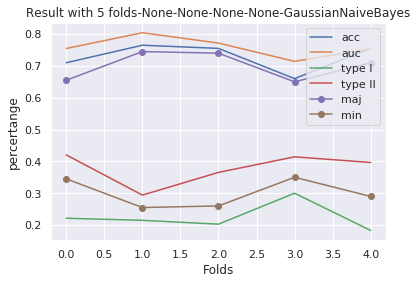

Discretization
-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------MDLP_R -----------------------------
Mean Accuracy: 0.7180000000000001
Mean Accuracy[0.71, 0.71, 0.725, 0.68, 0.765]
Mean Auc: 0.7417097743155218
Mean Auc[0.727863247863248, 0.7321515298688684, 0.7685436454093172, 0.7367472051929319, 0.7432432432432433]
Mean TypeII: 0.4058004629307961
Mean TypeII[0.3076923076923077, 0.3620689655172414, 0.3484848484848485, 0.4915254237288136, 0.5192307692307693]
Mean TypeI: 0.2328425834804341
Mean TypeI[0.2814814814814815, 0.2605633802816901, 0.23880597014925373, 0.24822695035460993, 0.13513513513513514]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


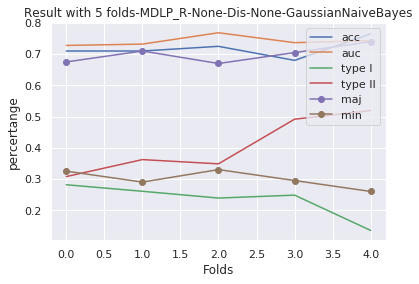

Discretization
-------------------------------CAIM_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.302
Mean Accuracy[0.305, 0.325, 0.32, 0.29, 0.27]
Mean Auc: 0.6070390161879875
Mean Auc[0.605731807996226, 0.6248851102941176, 0.5257352941176471, 0.528169014084507, 0.7506738544474394]
Mean TypeII: 0.00625
Mean TypeII[0.0, 0.03125, 0.0, 0.0, 0.0]
Mean TypeI: 0.9942276910764306
Mean TypeI[1.0, 0.9779411764705882, 1.0, 1.0, 0.9931972789115646]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


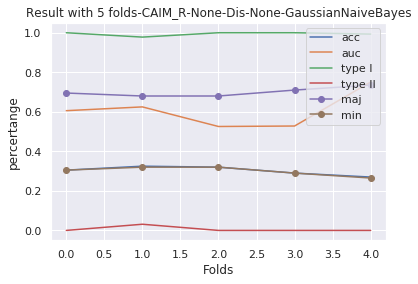

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------ChiMerge_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------ChiMerge_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.705
Mean Accuracy[0.725, 0.7, 0.685, 0.72, 0.695]
Mean Auc: 0.7483234058579552
Mean Auc[0.7515326361341508, 0.770362646275055, 0.7050000000000001, 0.7690666666666666, 0.7456550802139037]
Mean TypeII: 0.40238908670812956
Mean TypeII[0.423728813559322, 0.36507936507936506, 0.4166666666666667, 0.38, 0.4264705882352941]
Mean TypeI: 0.2486716861334038
Mean TypeI[0.2127659574468085, 0.27007299270072993, 0.2714285714285714, 0.24666666666666667, 0.24242424242424243]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


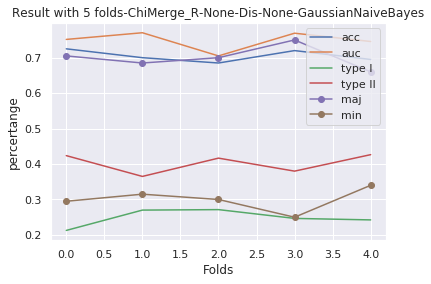

Discretization
-------------------------------CACC_R -----------------------------
Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CACC_R -----------------------------
Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CACC_R -----------------------------
Mean Accuracy: 0.6329999999999999
Mean Accuracy[0.565, 0.59, 0.685, 0.63, 0.695]
Mean Auc: 0.7542988468192253
Mean Auc[0.7592255717255717, 0.7243807673627974, 0.7690925426774484, 0.724945054945055, 0.7938502973852543]
Mean TypeII: 0.1726803629759572
Mean TypeII[0.09615384615384616, 0.1206896551724138, 0.2830188679245283, 0.21428571428571427, 0.14925373134328357]
Mean TypeI: 0.44921169616923085
Mean TypeI[0.5540540540540541, 0.528169014084507, 0.32653061224489793, 0.45384615384615384, 0.38345864661654133]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


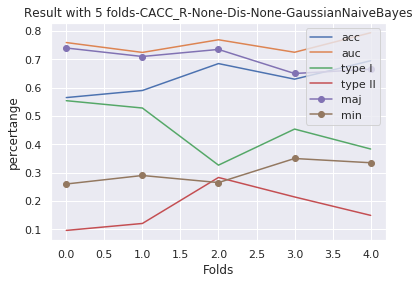

Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------Chi2_R -----------------------------
Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------Chi2_R -----------------------------
Mean Accuracy: 0.646
Mean Accuracy[0.58, 0.67, 0.635, 0.66, 0.685]
Mean Auc: 0.7400579757686927
Mean Auc[0.6704698809961968, 0.7841021825396824, 0.7205882352941176, 0.7667410714285714, 0.7583885085848951]
Mean TypeII: 0.2275048629035275
Mean TypeII[0.3508771929824561, 0.10714285714285714, 0.1875, 0.17857142857142858, 0.31343283582089554]
Mean TypeI: 0.4062631554891617
Mean TypeI[0.44755244755244755, 0.4166666666666667, 0.4485294117647059, 0.4027777777777778, 0.3157894736842105]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


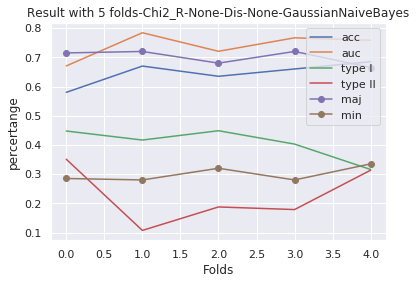

Compare Result-Germany_Original-GaussianNaiveBayes


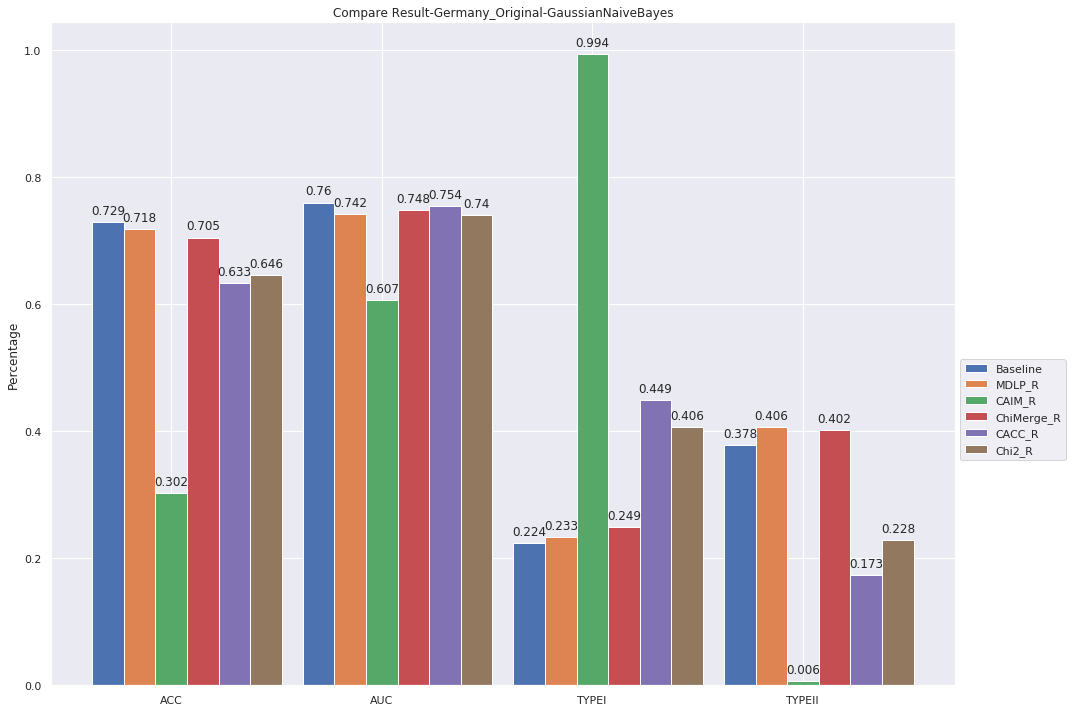

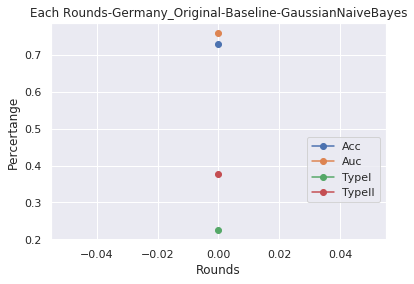

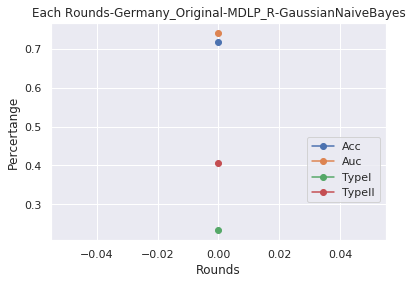

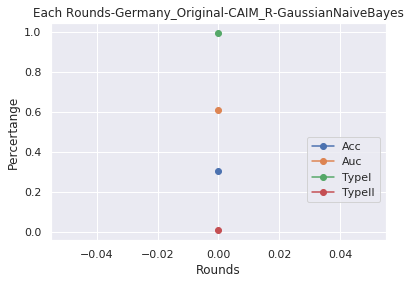

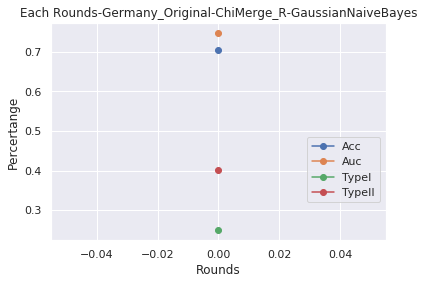

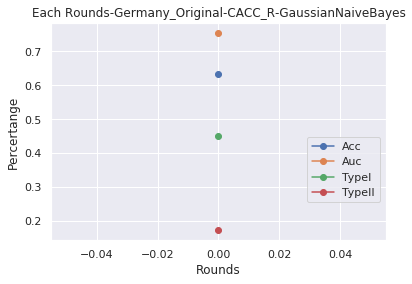

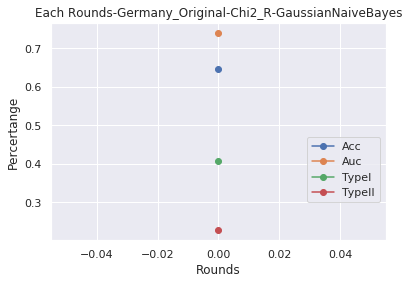

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.73 0.76   0.22    0.38          0.99
MDLP_R          0.72 0.74   0.23    0.41          1.25
CAIM_R          0.30 0.61   0.99    0.01          1.46
ChiMerge_R      0.70 0.75   0.25    0.40          3.08
CACC_R          0.63 0.75   0.45    0.17          1.87
Chi2_R          0.65 0.74   0.41    0.23         11.66

程式結束
Wall time: 25.6 s


In [13]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()
MultinomialNaiveBayes = MultinomialNB()
ComplementNaiveBayes = ComplementNB()
lboost = LogitBoost()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
    classifier_result_list = []
    
    for idx,classifi in enumerate(classifier_list):
        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            result_10times_CACC = []
            result_10times_Chi2 = []
            runnung_time_list = []

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'None','None','None-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIM_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_CACC = KFoldFuntion(clf, clf_name, 'CACC_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CACC.append(result_eachtimes_CACC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_Chi2 = KFoldFuntion(clf, clf_name, 'Chi2_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_Chi2.append(result_eachtimes_Chi2)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CACC,"CACC_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_Chi2,"Chi2_R",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))
        result_list.append(np.mean(result_10times_CACC, axis=0))
        result_list.append(np.mean(result_10times_Chi2, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP_R','CAIM_R','ChiMerge_R','CACC_R','Chi2_R'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{clf_name}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,clf_name=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    


t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))
t9 = Thread(target=run10times,args=(lboost,"LogitBoost"))
t10 = Thread(target=run10times,args=(ada,"AdaBoost"))
t11 = Thread(target=run10times,args=(knn,"KNN"))


#thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t0]
thread_list = [t8]
#thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
#thread_list = [t11,t10,t9,t7,t8]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [14]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)